In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")

C:\Users\yuhan\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%time
df = pd.read_csv("../input/blocks.csv")

Wall time: 700 ms


In [4]:
%%time
from prestep.datetime_extension import timedate_process
df = timedate_process(df)
cols = [c for c in df.columns if c not in ["Level","latBlock","lngBlock","month","day","hour","ClientMacAddr"]]

In [5]:
print(df.shape)
df.head()

(2273345, 22)


,Level,latBlock,lngBlock,month,day,hour,ClientMacAddr,dayofweek,holiday,Daily Rainfall Total (mm),...,Highest 120 Min Rainfall (mm),Mean Temperature (∞C),Maximum Temperature (∞C),Minimum Temperature (∞C),Mean Wind Speed (km/h),Max Wind Speed (km/h),eventFest,eventArt,eventinACM,eventinPSCS
0,0,0,20,4,1,10,1,6,False,8.8,...,8.6,27.7,32.9,25.6,7.2,22.3,False,False,False,False
1,0,0,20,4,2,16,1,0,False,1.6,...,1.6,28.7,32.8,26.5,8.3,29.5,False,False,False,False
2,0,0,20,4,3,10,1,1,False,0.0,...,0.0,28.9,33.0,26.8,7.2,25.9,False,False,False,False
3,0,0,20,4,3,16,1,1,False,0.0,...,0.0,28.9,33.0,26.8,7.2,25.9,False,False,False,False
4,0,0,20,4,3,17,1,1,False,0.0,...,0.0,28.9,33.0,26.8,7.2,25.9,False,False,False,False


In [6]:
df_val = df.loc[df.month>=6]
df = df.loc[df.month<6]
print(df_val.shape)
print(df.shape)

(965179, 22)
(1308166, 22)


In [21]:
df.loc[df.latBlock==1]


Level                                0
latBlock                             1
lngBlock                            18
month                                4
day                                  2
hour                                13
ClientMacAddr                        1
dayofweek                            0
holiday                          False
Daily Rainfall Total (mm)          1.6
Highest 30 Min Rainfall (mm)       1.6
Highest 60 Min Rainfall (mm)       1.6
Highest 120 Min Rainfall (mm)      1.6
Mean Temperature (∞C)             28.7
Maximum Temperature (∞C)          32.8
Minimum Temperature (∞C)          26.5
Mean Wind Speed (km/h)             8.3
Max Wind Speed (km/h)             29.5
eventFest                        False
eventArt                         False
eventinACM                       False
eventinPSCS                      False
Name: 3889, dtype: object

In [33]:
%%time
# format the input and output
#from model.produce_matrix import matrixTrans
def matrixTrans(df, level, between=7):
    tf = deepcopy(df.loc[df['Level'] == level])
    latMax = tf.latBlock.max()+1
    lngMax = tf.lngBlock.max()+1
    tf["order"] = tf.month * 10**2+ tf.day
    orders = sorted(tf["order"].unique())

    def generator():
        for hour in tf.hour.unique():
            yield hour

    g = generator()
    num = 0
    for h in g:
        num+= len(orders)-between
    features = np.zeros((num,lngMax,latMax,between))
    features_add = np.zeros((num,len(cols)))
    labels = np.zeros((num,lngMax,latMax))

    g = generator()
    index = 0
    for hour in g:
        temp = tf.loc[(tf.hour==hour)]
        for i in range(between, len(orders)):
            next_ = temp.loc[tf.order==orders[i]]
            if len(next_)==0:
                continue
            features_add[index,:] = next_.iloc[0][cols]
            for _,row in next_.iterrows():
                labels[index, row['lngBlock'],row['latBlock']] = row['ClientMacAddr']
            for b in range(between):
                prev = temp.loc[tf.order==orders[i-1-b]]
                for _, row in prev.iterrows():
                    features[index, row['lngBlock'],row['latBlock'],b] = row['ClientMacAddr']
            index += 1
            if index==num:
                return features,features_add, labels

    del tf
    features = features[:index,:,:,:]
    features_add = features_add[:index,:]
    labels = labels[:index,:,:]
    return features, features_add, labels

features,features_add, labels = matrixTrans(df, 0)
features_val,features_add_val, labels_val = matrixTrans(df_val, 0)
print(features.shape)
print(features_add.shape)
print(labels.shape)

(1158, 60, 20, 7)
(1158, 15)
(1158, 60, 20)
Wall time: 5min 1s


In [45]:
new_features = {}
new_features["distribution"] = features
new_features["add_info"] = features_add
new_features_val = {}
new_features_val["distribution"] = features_val
new_features_val["add_info"] = features_add_val

In [92]:
def cnn_model(features, labels, mode):
    # Input Layer
    add_info = features["add_info"]
    features=features["distribution"]
    size = features.shape
    kernel_size = [(3,3),(2,2),(2,2),(1,1)]
    strides = [1,1,1]
    filters = [32, 32, 16,1]

    input_layer = tf.reshape(features, [-1, size[1], size[2], size[3]])
    label_layer = tf.reshape(labels, [-1, size[1]*size[2]])

    # We only add conv layers with 'same' padding in our model
    # since It's a n*n -> n*n prediction (previous distribution -> future prediction)
    # dimensions should be kept same

    # Convolutional Layer and Pooling Layer#1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=filters[0],
      kernel_size=kernel_size[0],
      padding="same",
      activation=tf.nn.elu)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=filters[1],
      kernel_size=kernel_size[1],
      padding="same",
      activation=tf.nn.elu)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
      inputs=conv2,
      filters=filters[2],
      kernel_size=kernel_size[2],
      padding="same",
      activation=tf.nn.elu)
    
    conv4 = tf.layers.conv2d(
      inputs=conv3,
      filters=filters[3],
      kernel_size=kernel_size[3],
      padding="same",
      activation=tf.nn.elu)

    # Dense Layer
    conv4_flat = tf.reshape(conv4, [-1, size[1]*size[2]*filters[3]])
    #add_dense1 = tf.layers.dense(inputs=add_info, units = 4,activation=tf.nn.elu)
    add_dense = tf.layers.dense(inputs=add_info, units = size[1]*size[2]*filters[3])
    
    # Formerly, we use fully-connected layer to make output, 
    # but it costs too much computation resources and may lead to overfitting.
    # As an alternative, we use 1 filter in (1,1) size to make output.
    # Computing time and errors on val_data are reduced.
    #dense = tf.layers.dense(inputs=conv3_flat, units=1024)
    #dropout = tf.layers.dropout(inputs=dense, rate=0.8, training= mode == tf.estimator.ModeKeys.TRAIN)

    # Pred Layer
    pred = tf.keras.activations.relu(
            conv4_flat+add_dense) # We use relu activation here since we don't want a negative prediction

    # Loss
    loss = tf.losses.mean_squared_error(labels=label_layer, predictions=pred)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "distribution": pred
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.00005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "mse": tf.metrics.mean_squared_error(
          labels=label_layer, predictions=pred)
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [97]:
# Build the estimator
distribution_estimator = tf.estimator.Estimator(
    model_fn=cnn_model)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=new_features,
    y=labels,
    num_epochs=None,
    shuffle=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\yuhan\\AppData\\Local\\Temp\\tmps311kmr8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020DDAEA8358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [98]:
# the aim of rmse is 15, for now the rmse from cnn model is 13.8

In [99]:
%%time
# Train the CNN model step by step
trn_mse = []
val_mse = []
for i in range(50):
    distribution_estimator.train(
    input_fn=train_input_fn,
    steps=100)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=new_features,
    y=labels,
    num_epochs=1,
    shuffle=False)

    eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
    trn_mse.append(eval_results)
    
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=new_features_val,
    y=labels_val,
    num_epochs=1,
    shuffle=False)

    eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
    val_mse.append(eval_results)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:loss = 517.98645, step = 0
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:Loss for final step: 213.63991.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:24:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:24:06
INFO:tensorflow:Saving dict for global step 100:

INFO:tensorflow:Loss for final step: 407.73788.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:24:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:24:37
INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 304.2049, mse = 336.06424
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:24:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-500
INFO:tensorflow:Running local_init

INFO:tensorflow:Saving dict for global step 900: global_step = 900, loss = 292.5796, mse = 323.2127
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 900: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-900
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:25:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:25:08
INFO:tensorflow:Saving dict for global step 900: global_step = 900, loss = 197.74393, mse = 201.65373
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 900: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-900
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:

INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-1300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:25:38
INFO:tensorflow:Saving dict for global step 1300: global_step = 1300, loss = 193.85452, mse = 197.68399
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1300: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-1300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-1300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1300 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:loss = 229.20204, step = 1300
INFO:tensorflow:Saving 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-1700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1700 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:loss = 257.8015, step = 1700
INFO:tensorflow:Saving checkpoints for 1800 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:Loss for final step: 333.57855.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:26:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:loss = 388.81833, step = 2100
INFO:tensorflow:Saving checkpoints for 2200 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:Loss for final step: 352.04633.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:26:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-2200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:26:47
INFO:tensorflow:Saving dict for global step 2200: global_step = 2200, loss = 275.59952, mse = 304.41345
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2200: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-2200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:26:47
INFO:tensorflow

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:27:17
INFO:tensorflow:Saving dict for global step 2600: global_step = 2600, loss = 272.09235, mse = 300.53183
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2600: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-2600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:27:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-2600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:27:18
INFO:tensorflow:Saving dict for global step 2600: global_step = 2600, loss = 190.36113, mse = 194.11551
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2600: C:\Users\yuhan\AppData\Local\Te

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:27:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:27:48
INFO:tensorflow:Saving dict for global step 3000: global_step = 3000, loss = 189.7106, mse = 193.4511
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-3000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3000

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3400: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-3400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-3400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3400 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:loss = 273.89636, step = 3400
INFO:tensorflow:Saving checkpoints for 3500 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:Loss for final step: 263.04553.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:28:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\User

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3800 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:loss = 317.10657, step = 3800
INFO:tensorflow:Saving checkpoints for 3900 into C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt.
INFO:tensorflow:Loss for final step: 413.6129.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:28:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-3900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:28:57
INFO:tensorflow:Saving dict for global step 3900: global_step = 3900, loss = 262.97644, mse = 290.445
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3900: C:\Users\yuhan\AppData

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:29:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-4300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:29:27
INFO:tensorflow:Saving dict for global step 4300: global_step = 4300, loss = 260.32614, mse = 287.51727
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4300: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-4300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:29:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-4300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_i

INFO:tensorflow:Saving dict for global step 4700: global_step = 4700, loss = 257.862, mse = 284.79193
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4700: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-4700
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-23-07:29:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-4700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-23-07:29:58
INFO:tensorflow:Saving dict for global step 4700: global_step = 4700, loss = 192.00636, mse = 195.7886
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4700: C:\Users\yuhan\AppData\Local\Temp\tmps311kmr8\model.ckpt-4700
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHoo

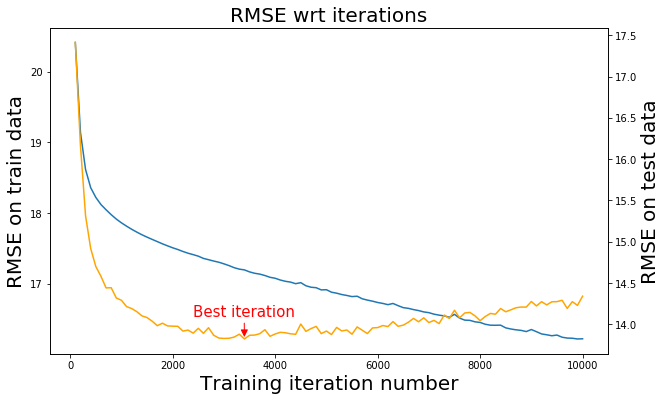

In [51]:
# Plot the result
# Results without additional information
trn_m = 1#np.mean((labels-np.mean(labels))**2)**0.5
val_m = 1#np.mean((labels-np.mean(labels_val))**2)**0.5

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot([x["global_step"] for x in trn_mse],
        [x["mse"]**0.5/trn_m for x in trn_mse])
ax1.set_ylabel('RMSE on train data',size=20)
ax1.set_xlabel('Training iteration number',size=20)
ax1.set_title("RMSE wrt iterations in CNN model",size=20)

ax2 = ax1.twinx()
ax2.plot([x["global_step"] for x in val_mse],
        [x["mse"]**0.5/val_m for x in val_mse], 'orange')
ax2.set_ylabel('RMSE on test data',size=20)

plt.annotate("Best iteration", xy=(3400,13.823),xytext = (2400,14.1),color="r",size=15,
             arrowprops={'arrowstyle':'-|>',"color":"r"})
plt.show()

In [48]:
# Results without additional information
# Best iteration is 3000
# Best RMSE on validation set is 13.823728666433093 (Target is <15)
print("The baseline RMSE:", 31.2)
print("The target RMSE:", 15)
print("best iteration:",val_mse[np.argmin([x["mse"] for x in val_mse])]["global_step"])
print("RMSE on train set:",trn_mse[np.argmin([x["mse"] for x in val_mse])]["mse"]**0.5)
print("best RMSE on validation data:",np.min([x["mse"]**0.5 for x in val_mse]))

The baseline RMSE: 31.2
The target RMSE: 15
best iteration: 3400
RMSE on train set: 17.194795149248197
best RMSE on validation data: 13.823728666433093


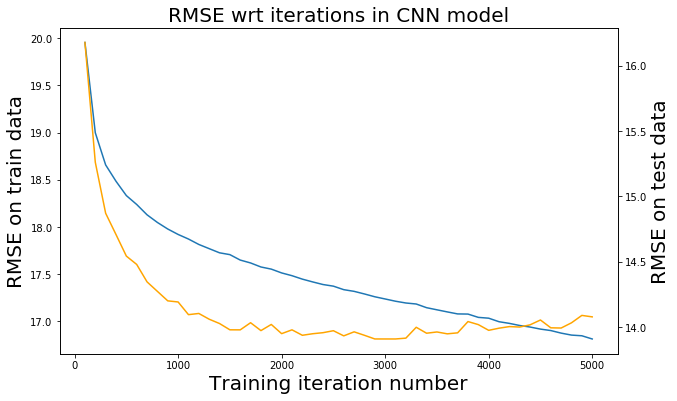

In [100]:
# Results with additional information
trn_m = 1#np.mean((labels-np.mean(labels))**2)**0.5
val_m = 1#np.mean((labels-np.mean(labels_val))**2)**0.5

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot([x["global_step"] for x in trn_mse],
        [x["mse"]**0.5/trn_m for x in trn_mse])
ax1.set_ylabel('RMSE on train data',size=20)
ax1.set_xlabel('Training iteration number',size=20)
ax1.set_title("RMSE wrt iterations in CNN model",size=20)

ax2 = ax1.twinx()
ax2.plot([x["global_step"] for x in val_mse],
        [x["mse"]**0.5/val_m for x in val_mse], 'orange')
ax2.set_ylabel('RMSE on test data',size=20)

#plt.annotate("Best iteration", xy=(3400,13.823),xytext = (2400,14.1),color="r",size=15,
#             arrowprops={'arrowstyle':'-|>',"color":"r"})
plt.show()

In [101]:
# Results without additional information
print("The baseline RMSE:", 31.2)
print("The target RMSE:", 15)
print("best iteration:",val_mse[np.argmin([x["mse"] for x in val_mse])]["global_step"])
print("RMSE on train set:",trn_mse[np.argmin([x["mse"] for x in val_mse])]["mse"]**0.5)
print("best RMSE on validation data:",np.min([x["mse"]**0.5 for x in val_mse]))

The baseline RMSE: 31.2
The target RMSE: 15
best iteration: 3000
RMSE on train set: 17.23723096520019
best RMSE on validation data: 13.908669799123663
